#遷移學習(binary改categorical)計算confusion matrix

#resnet50

### Import必要套件

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/TFkeras/catdog.zip /content

In [4]:
!unzip /content/catdog.zip -d /content/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/catdog/train/dog/dog.5499.jpg  
  inflating: /content/catdog/train/dog/dog.55.jpg  
  inflating: /content/catdog/train/dog/dog.550.jpg  
  inflating: /content/catdog/train/dog/dog.5500.jpg  
  inflating: /content/catdog/train/dog/dog.5501.jpg  
  inflating: /content/catdog/train/dog/dog.5502.jpg  
  inflating: /content/catdog/train/dog/dog.5503.jpg  
  inflating: /content/catdog/train/dog/dog.5504.jpg  
  inflating: /content/catdog/train/dog/dog.5505.jpg  
  inflating: /content/catdog/train/dog/dog.5506.jpg  
  inflating: /content/catdog/train/dog/dog.5507.jpg  
  inflating: /content/catdog/train/dog/dog.5508.jpg  
  inflating: /content/catdog/train/dog/dog.5509.jpg  
  inflating: /content/catdog/train/dog/dog.551.jpg  
  inflating: /content/catdog/train/dog/dog.5510.jpg  
  inflating: /content/catdog/train/dog/dog.5511.jpg  
  inflating: /content/catdog/train/dog/dog.5512.jpg  
  inflating: /content/catdog/train/dog/dog.5513.jpg  
  inflating

### cats_vs_dogs
載入cats_vs_dogs數據集

In [5]:
image_size = [128, 128] #省時間調128,128，應該要調[299,299,3]
batch_size = 64

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      "catdog/train",
      validation_split=0.2,
      subset="training",
      seed=1001,
      image_size=image_size,
      batch_size=None,
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      "catdog/train",
      validation_split=0.2,
      subset="validation",
      seed=1001,
      image_size=image_size,
      batch_size=None,
)

Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      "catdog/test",
      validation_split=0.0,
      shuffle=False,
      seed=1001,
      image_size=image_size,
      batch_size=None,
)

Found 5000 files belonging to 2 classes.


In [9]:
for x, y in train_ds.take(1):
  print(x)
  print(y)

tf.Tensor(
[[[193.18594  203.18594  204.23578 ]
  [149.42386  159.93665  156.85355 ]
  [129.21814  141.21033  128.46814 ]
  ...
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]]

 [[204.04947  216.55835  210.59137 ]
  [ 97.75406  111.09711  100.28601 ]
  [ 46.87851   59.886322  42.365356]
  ...
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]]

 [[135.70572  149.67838  134.05646 ]
  [ 81.30185   96.274506  76.61331 ]
  [ 98.45297  112.43344   87.586   ]
  ...
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]]

 ...

 [[147.13754  150.1102   123.22513 ]
  [100.78595  103.76395   74.49402 ]
  [103.010864 107.00305   72.08899 ]
  ...
  [214.94595  217.94595  222.94595 ]
  [215.87604  218.87604  223.87604 ]
  [214.63919  217.63919  222.63919 ]]

 [[123.1637   125.1637   102.36682 ]
  [ 83.674774  85.87009   

In [10]:
train_ds.class_names

['cat', 'dog']

In [11]:
labels = train_ds.class_names

In [12]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x

def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

def parse_aug_fn(x, y):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(x, tf.float32)
    x = tf.keras.applications.resnet.preprocess_input(x)
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x) # tf.cond: tensorflow的if / else條件判斷式
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    return x, tf.one_hot(y, 2)

def parse_fn(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.keras.applications.resnet.preprocess_input(x)
    return x, tf.one_hot(y, 2)

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式

train_ds = train_ds.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-1

創建RESNET50網路模型

In [14]:
# 創建模型(不包含全連接層)，最後一層卷積加上GlobalAveragePooling
base_model = tf.keras.applications.ResNet50(include_top=False,
                               weights='imagenet',
                               pooling='avg',
                               input_shape=image_size+[3]) # [128, 128, 3] # w,h,c
# 將剛創建的ResNet50模型接上兩層全連接層，並且最後一層使用Softmax輸出
model_1 = tf.keras.Sequential()
model_1.add(base_model)
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dense(2, activation='softmax'))



94765736/94765736 [==============================] - 5s 0us/step


In [15]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23850242 (90.98 MB)
Trainable params: 23797122 (90.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [16]:
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/TFkeras/ResNet50.h5',
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')
# 設定停止訓練的條件(當Accuracy超過5迭代沒有上升的話訓練會終止)
model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)

In [17]:
adam = optimizers.Adam(learning_rate=1e-3)
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.0001)

model_1.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

In [18]:
history = model_1.fit(train_ds,
                        validation_data=val_ds,
                        epochs=30,
                        callbacks=[rlr, model_mckp, model_esp])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.3498 - categorical_accuracy: 0.8513

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 121s 318ms/step - loss: 0.3498 - categorical_accuracy: 0.8513 - val_loss: 0.5032 - val_categorical_accuracy: 0.7680 - lr: 0.0010
Epoch 2/30
250/250 [==============================] - 75s 295ms/step - loss: 0.2634 - categorical_accuracy: 0.8888 - val_loss: 0.4225 - val_categorical_accuracy: 0.7857 - lr: 0.0010
Epoch 3/30
250/250 [==============================] - 73s 290ms/step - loss: 0.2351 - categorical_accuracy: 0.9002 - val_loss: 0.3250 - val_categorical_accuracy: 0.8580 - lr: 0.0010
Epoch 4/30
250/250 [==============================] - 68s 269ms/step - loss: 0.2153 - categorical_accuracy: 0.9094 - val_loss: 0.3883 - val_categorical_accuracy: 0.7995 - lr: 0.0010
Epoch 5/30
250/250 [==============================] - ETA: 0s - loss: 0.2044 - categorical_accuracy: 0.9127
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
250/250 [==============================] - 69s 271ms/step - loss: 0.2044 - categorical_accuracy: 

### predict

In [19]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(model, size, image_size):
    predictions =[]
    true_y = []
    for x,y in test_ds:
        predprob = model.predict(x)
        # decoding one-hot
        prediction = np.argmax(predprob, axis=1)
        y = np.argmax(y, axis =1)

        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
    matrix = confusion_matrix(true_y, predictions)

    return matrix

In [20]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/ResNet50.h5')
conf_matrix_inc = get_conf_matrix(model, 5000, image_size)
print(conf_matrix_inc[:,:])
del model
K.clear_session()

1/1 [==============================] - 1s 1s/step
[[2397  103]
 [  44 2456]]


Confusion matrix, without normalization
[[2397  103]
 [  44 2456]]


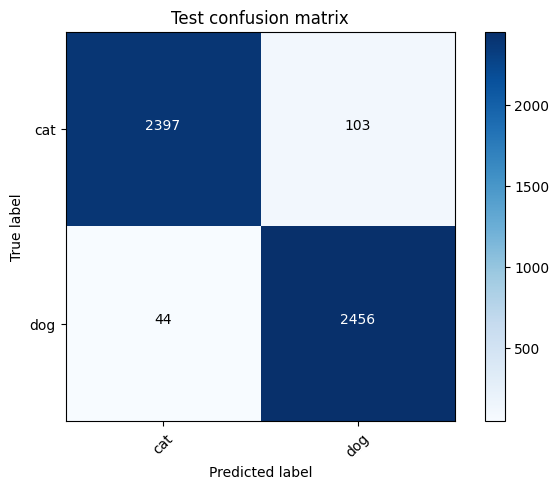

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=False`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix_inc, labels, title = "Test confusion matrix")

In [22]:
sum([conf_matrix_inc[i, i] for i in range(2)])/5000.0

0.9706